In [1]:
using LinearAlgebra

In [2]:
mutable struct LinearProgram 
    A
    b
    c
end

# Problem Description

Let’s imagine we’re preparing to send a team of astronauts to Mars. We have been tasked to decide how much fruit and how much frozen meals we should send with them. The goal here is to maximize the desirability of the food to the astronauts because we want to keep them happy. Now keep in mind this is just a simple example to get us started. In reality you would probably be more concerned about nutrition content, calorie intake, preservability of the food and so on. But we’re starting simple!

We assume our vehicle can support 4000 kg of fresh fruit $x_f$ and 6000 kg of frozen meals $x_p$. However, we only have 8000 kg of payload available to devote to food supplies. The overall goal is to maximize the desirability of the food


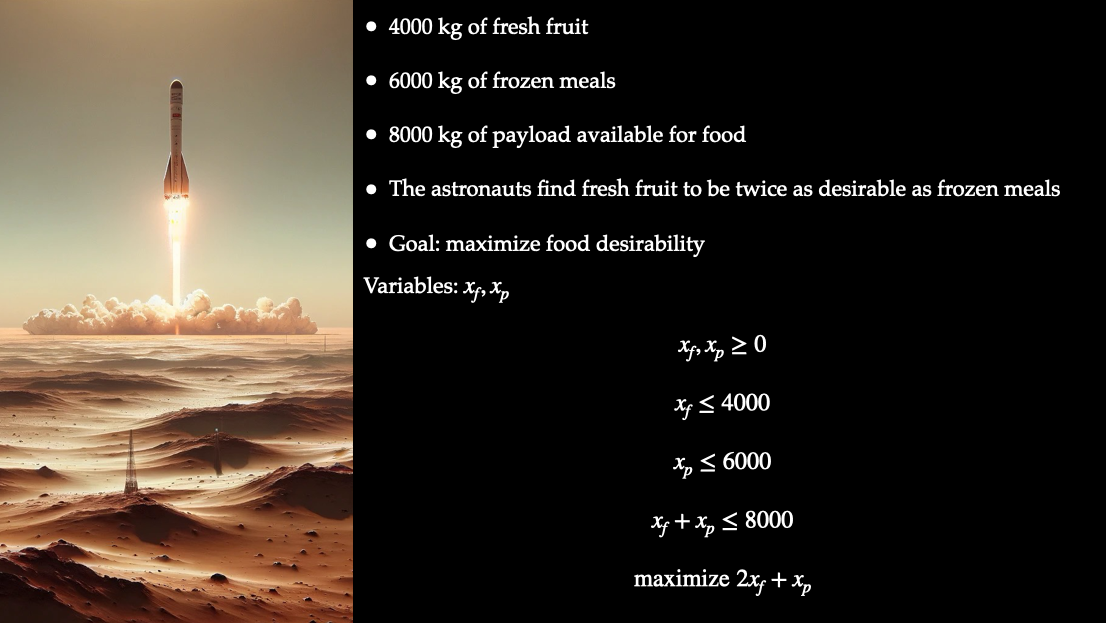

In [1]:
# Include image description in notebook
using Images 

img = load("description.png")
img

# Get Vertex

In [3]:
function get_vertex(B, LP)
    A, b, c = LP.A, LP.b, LP.c
    b_inds = sort(B)
    AB = A[:,b_inds]
    xB = AB\b
    x = zeros(length(c)) 
    x[b_inds] = xB 
    return x
end

get_vertex (generic function with 1 method)

# Edge Transition

In [4]:
function edge_transition(LP, B, q) 
    A, b, c = LP.A, LP.b, LP.c
    n = size(A, 2)
    b_inds = sort(B)
    n_inds = sort!(setdiff(1:n, B))
    AB = A[:,b_inds]
    d = AB\A[:,n_inds[q]]
    xB = AB\b
    
    p, xq′ = 0, Inf
    for i in 1 : length(d)
        if d[i] > 0
            v = xB[i] / d[i]
            if v < xq′
                p, xq′ = i, v 
            end
        end
    end
    return (p, xq′) 
end


edge_transition (generic function with 1 method)

# Step LP! 

In [5]:
function step_lp!(B, LP)
    A, b, c = LP.A, LP.b, LP.c
    n = size(A, 2)
    b_inds = sort(B)
    n_inds = sort!(setdiff(1:n, B)) 
    AB, AV = A[:,b_inds], A[:,n_inds] 
    xB = AB\b
    cB = c[b_inds]
    λ = AB' \ cB
    cV = c[n_inds]
    μV = cV - AV'*λ

    q, p, xq′, Δ = 0, 0, Inf, Inf 
    for i in 1 : length(μV)
        if μV[i] < 0
            pi, xi′ = edge_transition(LP, B, i) 
            if μV[i]*xi′ < Δ # Greedy heuristic
                q, p, xq′, Δ = i, pi, xi′, μV[i]*xi′ 
            end
        end 
    end
    if q == 0
        return (B, true) # optimal point found
    end

    if isinf(xq′)
        error("unbounded") 
    end
    
    j = findfirst(isequal(b_inds[p]), B)
    B[j] = n_inds[q] # swap indices
    return (B, false) # new vertex but not optimal
end


step_lp! (generic function with 1 method)

# Minimize LP!

In [6]:
function minimize_lp!(B, LP) 
    done = false
    while !done
        B, done = step_lp!(B, LP) 
    end
    return B 
end

minimize_lp! (generic function with 1 method)

# Minimize LP

In [14]:
function minimize_lp(LP)
    A, b, c = LP.A, LP.b, LP.c
    m, n = size(A)
    z = ones(m)
    Z = Matrix(Diagonal([j ≥ 0 ? 1 : -1 for j in b]))

    A′ = hcat(A, Z)
    b′ = b
    c′ = vcat(zeros(n), z)
    LP_init = LinearProgram(A′, b′, c′)
    B = collect(1:m).+n
    minimize_lp!(B, LP_init)

    if any(i-> i > n, B)
        error("infeasible") 
    end

    A′′ = [A          Matrix(1.0I, m, m);
           zeros(m,n) Matrix(1.0I, m, m)]
    b′′ = vcat(b, zeros(m))
    c′′ = vcat(c, zeros(m))
    LP_opt = LinearProgram(A′′, b′′, c′′) 
    minimize_lp!(B, LP_opt)
    return get_vertex(B, LP_opt)[1:n]
end


minimize_lp (generic function with 1 method)

# Example

To convert the given linear programming problem into equality form (also known as standard form), you must convert all inequalities into equalities by introducing slack variables. Slack variables are non-negative variables added to the less-than-or-equal-to constraints to convert them into equations. Here's how you can convert your LP problem:

### Original LP Problem:
**Objective:**
$$
\text{minimize } -2x_f - x_p
$$

**Constraints:**
$$
x_f + x_p \leq 8000 \\
x_p \leq 6000 \\
x_f \leq 4000 \\
x_f \geq 0 \\
x_p \geq 0
$$

### Convert to Equality Form:

**1. Introduce Slack Variables:**
Add a slack variable $s_1$ to the first constraint, $s_2$ to the second constraint, and $s_3$ to the third constraint. Slack variables $s_1$, $s_2$, and $s_3$ are non-negative.

$$
x_f + x_p + s_1 = 8000 \\
x_p + s_2 = 6000 \\
x_f + s_3 = 4000
$$

**2. Non-Negativity Constraints:**
The variables $x_f$, $x_p$, $s_1$, $s_2$, and $s_3$ must all be non-negative:

$$
x_f \geq 0 \\
x_p \geq 0 \\
s_1 \geq 0 \\
s_2 \geq 0 \\
s_3 \geq 0
$$

### Equality Form LP:
**Objective:**
$$
\text{minimize } -2x_f - x_p
$$

**Constraints:**
$$
x_f + x_p + s_1 = 8000 \\
x_p + s_2 = 6000 \\
x_f + s_3 = 4000
$$

**Non-negativity:**
$$
x_f, x_p, s_1, s_2, s_3 \geq 0
$$


In [15]:
A = [1 1 1 0 0; 
     0 1 0 1 0;
     1 0 0 0 1]
b = [8000; 6000; 4000]
c = [-2; -1; 0; 0; 0];

In [16]:
LP = LinearProgram(A, b, c);

In [17]:
x = minimize_lp(LP)

c′′ = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
c′′ = [-2.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


5-element Vector{Float64}:
 4000.0
 4000.000000000001
    0.0
 1999.9999999999982
    0.0

In [18]:
sum(c .* x)

-12000.0

# Plotting

In [12]:
using ImplicitEquations
using Plots
using LaTeXStrings
using Colors
using Measures

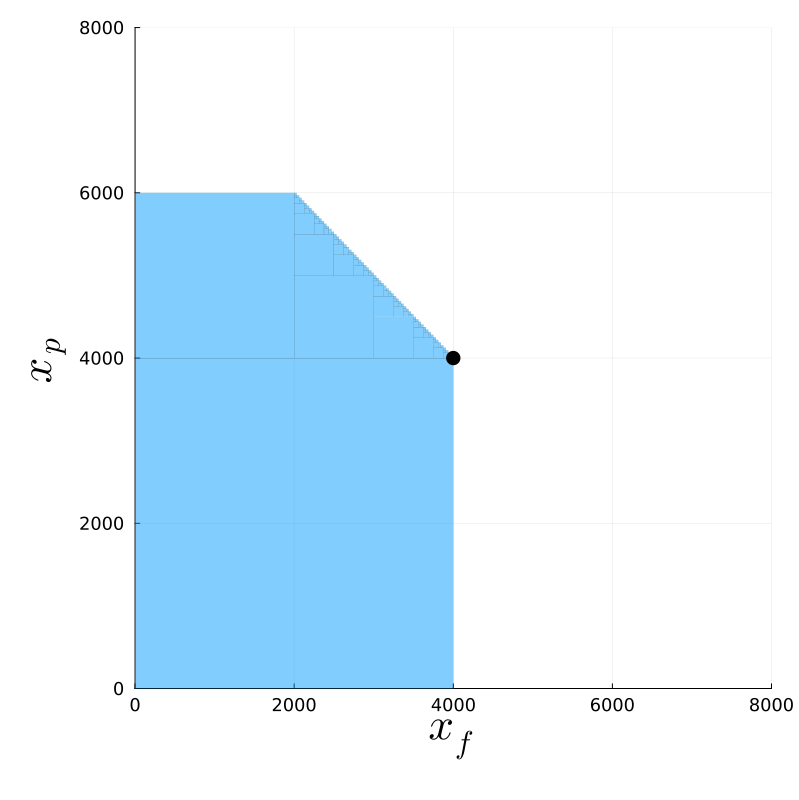

In [13]:
f1(x_f,x_p) = x_f
f2(x_f,x_p) = x_p
f3(x_f,x_p) = x_f + x_p
plot((f1 ≪ 4000.0) & (f2 ≪ 6000.0) & (f3 ≪ 8000.0), xlims=(0, 8000), ylims=(0, 8000), legend=false, fill=(0, 0.5, RGB(0.02, 0.61, 0.99)))

# Scatter the optimal point
scatter!([x[1]], [x[2]], color = :black, label = "Optimal (x_f, x_p)", xlabel=L"x_f", ylabel=L"x_p", markersize=8)

# Set xaxis font size 
plot!(xtickfont = font(12), ytickfont = font(12), legendfont = font(12), titlefont = font(12), guidefont = font(30), size=(800, 800),margin = 5mm)